# Import libraries

In [1]:
# for Kaggle
# !pip install -U lightautoml

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# edited by Mayur

import os
import re
import gc
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
from tqdm.notebook import tqdm as tqdm_notebook

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

def reduce_mem_usage(df, silent=True, allow_categorical=True, float_dtype="float32"):
    """ 
    Iterates through all the columns of a dataframe and downcasts the data type
     to reduce memory usage. Can also factorize categorical columns to integer dtype.
    """
    def _downcast_numeric(series, allow_categorical=allow_categorical):
        """
        Downcast a numeric series into either the smallest possible int dtype or a specified float dtype.
        """
        if pd.api.types.is_sparse(series.dtype) is True:
            return series
        elif pd.api.types.is_numeric_dtype(series.dtype) is False:
            if pd.api.types.is_datetime64_any_dtype(series.dtype):
                return series
            else:
                if allow_categorical:
                    return series
                else:
                    codes, uniques = series.factorize()
                    series = pd.Series(data=codes, index=series.index)
                    series = _downcast_numeric(series)
                    return series
        else:
            series = pd.to_numeric(series, downcast="integer")
        if pd.api.types.is_float_dtype(series.dtype):
            series = series.astype(float_dtype)
        return series

    if silent is False:
        start_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    if df.ndim == 1:
        df = _downcast_numeric(df)
    else:
        for col in df.columns:
            df.loc[:, col] = _downcast_numeric(df.loc[:,col])
    if silent is False:
        end_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
        print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df

# Load necessary files

In [3]:
items = pd.read_csv("items.csv.zip")
item_categories = pd.read_csv("item_categories.csv")
sales_train = pd.read_csv("sales_train.csv.zip", parse_dates=['date'])
shops = pd.read_csv("shops.csv")
sales_test = pd.read_csv("test.csv.zip")
submission = pd.read_csv("sample_submission.csv.zip")

# for Kaggle

# PATH = '../input/competitive-data-science-predict-future-sales'

# items           = pd.read_csv(os.path.join(PATH,'items.csv'))
# item_categories = pd.read_csv(os.path.join(PATH,'item_categories.csv'))
# sales_train     = pd.read_csv(os.path.join(PATH,'sales_train.csv'), parse_dates=['date'])
# shops           = pd.read_csv(os.path.join(PATH,'shops.csv'))
# sales_test      = pd.read_csv(os.path.join(PATH,'test.csv'))
# submission      = pd.read_csv(os.path.join(PATH,'sample_submission.csv'))

# drop duplicates
sales_train.drop_duplicates(inplace=True)

# add date_block_num feature to test df, set it value to 34
sales_test['date_block_num'] = 34
sales_test.drop('ID', axis=1, inplace=True)
sales_test.date_block_num = sales_test.date_block_num.astype(np.int8)

# Research dataset

In [4]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


Does train dataset contains zeros?

In [5]:
sales_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

Research features

### item_cnt_day

<AxesSubplot:xlabel='item_cnt_day'>

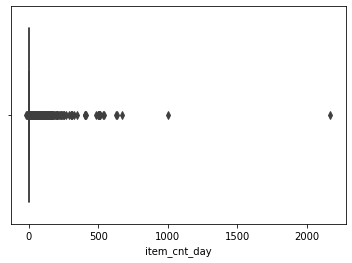

In [6]:
sns.boxplot(x='item_cnt_day', data=sales_train)

(array([2.934458e+06, 1.204000e+03, 1.110000e+02, 3.100000e+01,
        1.100000e+01, 5.000000e+00, 4.000000e+00, 4.000000e+00,
        0.000000e+00, 8.000000e+00, 2.000000e+00, 1.000000e+00,
        2.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00]),
 array([ -22.   ,   32.775,   87.55 ,  142.325,  197.1  ,  251.875,
         306.65 ,  361.425,  416.2  ,  470.975,  525.75 ,  580.525,
         635.3  ,  690.075,  744.85 ,  799.625,  854.4  ,  909.175,
         963.95 , 1018.725, 1073.5  , 1128.275, 1183.05 , 1237.825,
        1292.6  , 1347.375, 1402.15 , 1456.925, 1511.7  , 1566.475,
        1621.25 , 

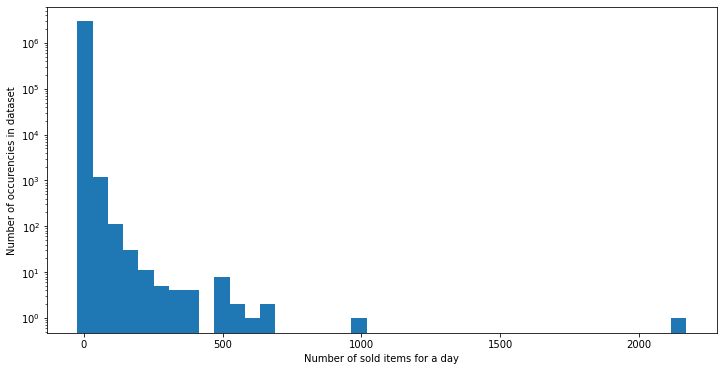

In [7]:
plt.figure(figsize=(12,6))
plt.xlabel('Number of sold items for a day')
plt.ylabel('Number of occurencies in dataset')
plt.yscale('log')
plt.hist(sales_train.item_cnt_day, bins=40)

In [8]:
sales_train.item_cnt_day.describe()

count    2.935843e+06
mean     1.242641e+00
std      2.618837e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

Group number of sold items by date_block and plot.

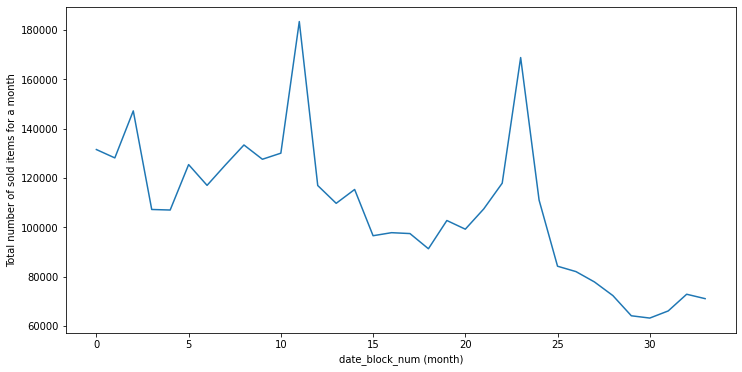

In [9]:
plt.figure(figsize=(12,6))
plt.xlabel('date_block_num (month)')
plt.ylabel('Total number of sold items for a month')
plt.plot(sales_train.groupby(['date_block_num']).agg({'item_cnt_day': 'sum'}).reset_index()['item_cnt_day'])

There is an obvious trend with peaks at New Year holidays.

### item_price

Distribution of items price and outliers

In [10]:
sales_train.item_price.describe()

count    2.935843e+06
mean     8.908535e+02
std      1.729801e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

<AxesSubplot:xlabel='item_price'>

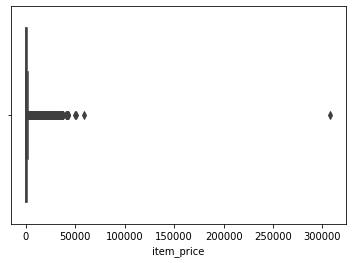

In [11]:
sns.boxplot(x='item_price', data=sales_train)

### date_block_num

In [12]:
sales_train.date_block_num.describe()

count    2.935843e+06
mean     1.456991e+01
std      9.422992e+00
min      0.000000e+00
25%      7.000000e+00
50%      1.400000e+01
75%      2.300000e+01
max      3.300000e+01
Name: date_block_num, dtype: float64

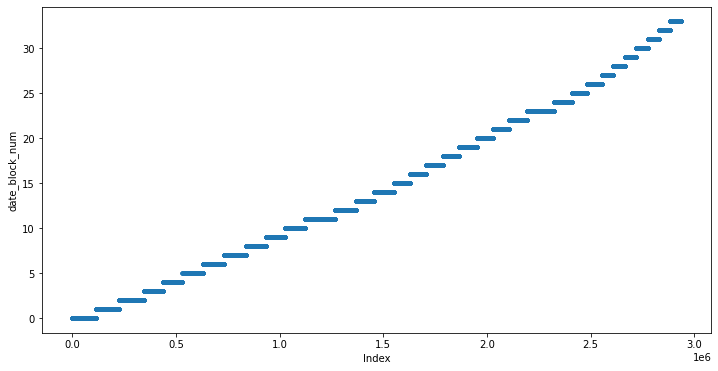

In [13]:
plt.figure(figsize=(12,6))
plt.xlabel('Index')
plt.ylabel('date_block_num')
plt.plot(sales_train.date_block_num, '.')

We can suppose, that dataset was built by concatenating of smaller datasets for each date block

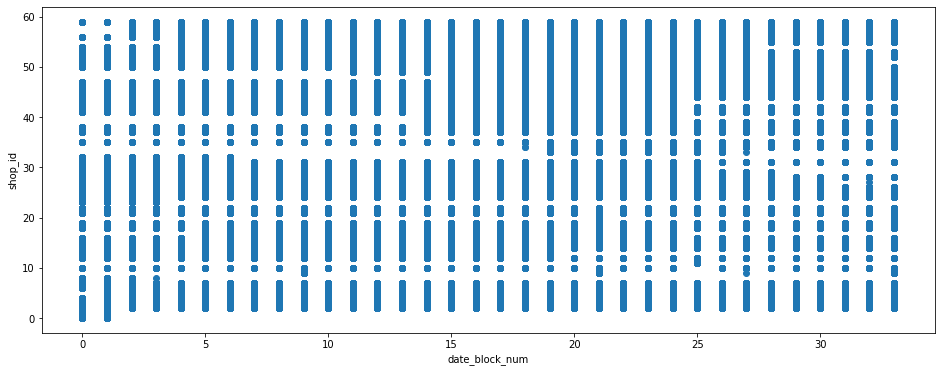

In [14]:
plt.figure(figsize=(16, 6))
plt.xlabel('date_block_num')
plt.ylabel('shop_id')
plt.scatter(sales_train.date_block_num, sales_train.shop_id)

### shop_id

What shops are presented in train set but aren't presented in the test set?

In [15]:
# missed_ind = sorted([c for c in sales_train.shop_id.unique() if c not in sales_test.shop_id.unique()])
# sales_train.shop_id.value_counts().sort_index().iloc[missed_ind].plot.bar(figsize=(12, 8))

Me may don't need shops with id's 8, 9, 11, 20 and 40. 

We can see strong vertical pattern. This means that data wasn't shaffled for shops. We also can see, that data for some shops and date blocks are missing.

# Fix errors in dataset

## Fix wrong shops id's

Some shop names look similar

In [16]:
print(shops.loc[shops.shop_id.isin([0, 57]), 'shop_name'])
print(shops.loc[shops.shop_id.isin([1, 58]), 'shop_name'])
print(shops.loc[shops.shop_id.isin([10, 11]), 'shop_name'])
print(shops.loc[shops.shop_id.isin([39, 40]), 'shop_name'])

0     !Якутск Орджоникидзе, 56 фран
57          Якутск Орджоникидзе, 56
Name: shop_name, dtype: object
1     !Якутск ТЦ "Центральный" фран
58          Якутск ТЦ "Центральный"
Name: shop_name, dtype: object
10    Жуковский ул. Чкалова 39м?
11    Жуковский ул. Чкалова 39м²
Name: shop_name, dtype: object
39              РостовНаДону ТРК "Мегацентр Горизонт"
40    РостовНаДону ТРК "Мегацентр Горизонт" Островной
Name: shop_name, dtype: object


Let's correct this

In [17]:
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
sales_test.loc[sales_test.shop_id == 0, 'shop_id'] = 57

sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
sales_test.loc[sales_test.shop_id == 1, 'shop_id'] = 58

sales_train.loc[sales_train.shop_id == 11, 'shop_id'] = 10 # shop_id 11 isn't presented in the test set
sales_test.loc[sales_test.shop_id == 11, 'shop_id'] = 10

sales_train.loc[sales_train.shop_id == 40, 'shop_id'] = 39
sales_test.loc[sales_test.shop_id == 40, 'shop_id'] = 39

# keep only shops that are in the test set
sales_train = sales_train.loc[sales_train.shop_id.isin(sales_test["shop_id"].unique()), :]

### Fix wrong prices

Some of prices may be wrong. Let's find them. At first we look for prices with big difference between min and max price for each item and find the most frequent normal prices for them.

In [18]:
sales_train = sales_train[(sales_train.item_price > 0) & (sales_train.item_price < 50000)]

# for each item get price with mode value > 5
def amode(col):
    i = 0
    res = 0
    count = col.value_counts().index
    while res <= 5 and i < len(count):
        res = count[i]
        i += 1
    return res

def alast(col):
    return res
    
# group train dataset by prices, aggregate by price mode
item_prices = sales_train[['item_id', 'item_price']].groupby('item_id').agg({'item_price': [np.min, 
                                                                                            np.max, 
                                                                                            amode]})
# add feature for difference between min and max prices
item_prices['price_diff'] = abs(item_prices.item_price.amax/item_prices.item_price.amin)

# get all prices with the difference between min and max prices more than 15 and min price less than 5
# save indexes of these prices
wrong_prices = item_prices[(item_prices.item_price.amin <= 5) & 
                           (item_prices.price_diff >= 15)].sort_values('price_diff', ascending=False)

wrong_prices.head()

item_price                    price_diff
              amin    amax   amode              
item_id                                         
11865         0.07   729.0   329.0  10414.285714
11857         0.10   729.0   319.0   7290.000000
11864         0.07   469.0   269.0   6700.000000
1836          0.50  2599.0  1999.0   5198.000000
7019          0.50  2599.0  2599.0   5198.000000

Fix wrong prices

In [19]:
for i_id in list(wrong_prices.index):
    sales_train.loc[(sales_train.item_id == i_id) & 
                    (sales_train.item_price <= 5), 'item_price'] = wrong_prices.loc[i_id, 'item_price'].amode
    
del wrong_prices
gc.collect()

5

### Fix wrong dates

Let's add year, month and day features and check if they are correct.

In [20]:
sales_train.date = pd.to_datetime(sales_train.date, format='%Y-%m-%d')
sales_train['year'] = sales_train.date.dt.year
sales_train['month'] = sales_train.date.dt.month
sales_train['day'] = sales_train.date.dt.day
sales_train[(sales_train.month == 1) & (sales_train.year == 2013) & sales_train.date_block_num > 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day
115846,2013-01-02,1,50,3705,1499.00,2.0,2013,1,2
115861,2013-01-02,1,50,3745,799.00,1.0,2013,1,2
115946,2013-01-02,1,50,5262,719.52,1.0,2013,1,2
115979,2013-01-02,1,50,5272,399.56,1.0,2013,1,2
116070,2013-01-02,1,50,4886,899.00,1.0,2013,1,2
...,...,...,...,...,...,...,...,...,...
1267281,2013-01-12,11,46,4477,899.00,1.0,2013,1,12
1267430,2013-01-12,11,46,5620,590.00,1.0,2013,1,12
1267455,2013-01-12,11,46,5643,2490.00,1.0,2013,1,12
1267552,2013-01-12,11,46,5672,2590.00,1.0,2013,1,12


As we can see, some date values do not correspond to date_block_num values. Further investigation lead to conclusion, that this is because date values are wrong: day and month are confused with each other. Let's fix that.

In [21]:
def add_month(col):
    return int(divmod(col, 12)[1] + 1)

sales_train['month_from_date_block'] = sales_train.date_block_num.apply(add_month)

date_index = sales_train.loc[sales_train.month != sales_train.month_from_date_block].index

day = sales_train.loc[date_index, 'day']
month = sales_train.loc[date_index, 'month']

sales_train.loc[date_index, 'day'] = month
sales_train.loc[date_index, 'month'] = day

# fix date with correct month and year values
sales_train.date = sales_train.year.astype(str) + '-' + sales_train.month.astype(str) + '-' + sales_train.day.astype(str)
sales_train.date = pd.to_datetime(sales_train.date, format='%Y-%m-%d')

sales_train.drop(['month_from_date_block', 'year', 'month'], axis=1, inplace=True)

### Clip outliers for item_cnt_day

In [22]:
sales_train = sales_train[(sales_train['item_cnt_day'] > 0) & (sales_train['item_cnt_day'] < 1000)]

# Investigate data distribution for train and test datasets.

In [23]:
sales_train_gr = sales_train.groupby(['date_block_num', 
                                      'shop_id', 'item_id'], as_index=False).agg({'item_price': 'mean', 
                                                                                  'item_cnt_day': 'sum'})

sales_train_gr.rename({'item_cnt_day': 'item_cnt_month'}, axis=1, inplace=True)

Let's investigate distribution of items and shops according to mean date block number.

Train dataset.

25

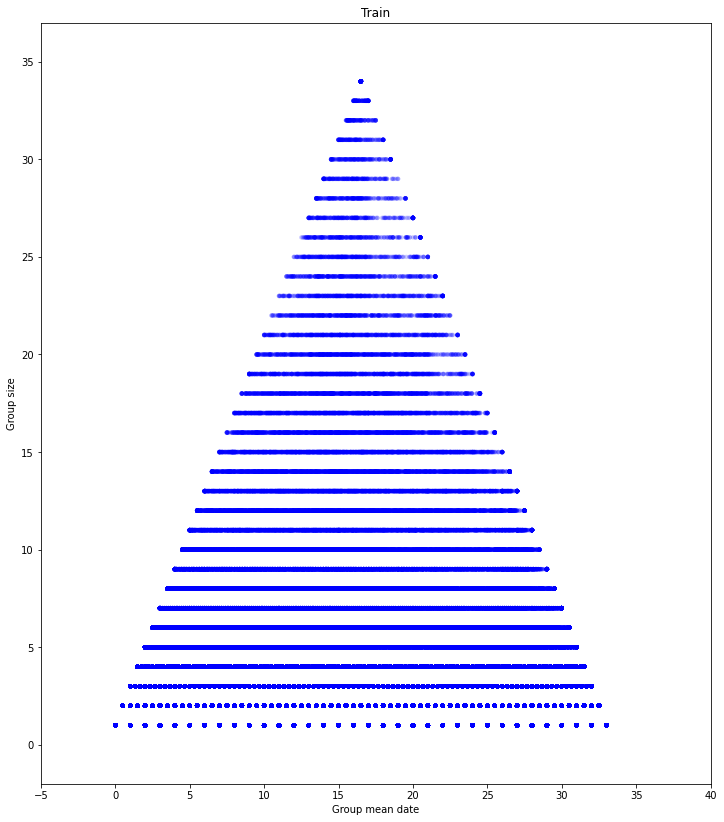

In [24]:
from matplotlib import pyplot as plt

g = sales_train_gr.groupby(['shop_id', 'item_id'])

plt.figure(figsize=(12,14))
plt.scatter(g.date_block_num.mean(), g.size(), edgecolor = 'none', alpha = 0.2, s=20, c='b')
plt.xlabel('Group mean date')
plt.ylabel('Group size')
plt.ylim(-2, 37)
plt.xlim(-5, 40)
plt.title('Train');

del sales_train_gr
gc.collect()

Test dataset

3328

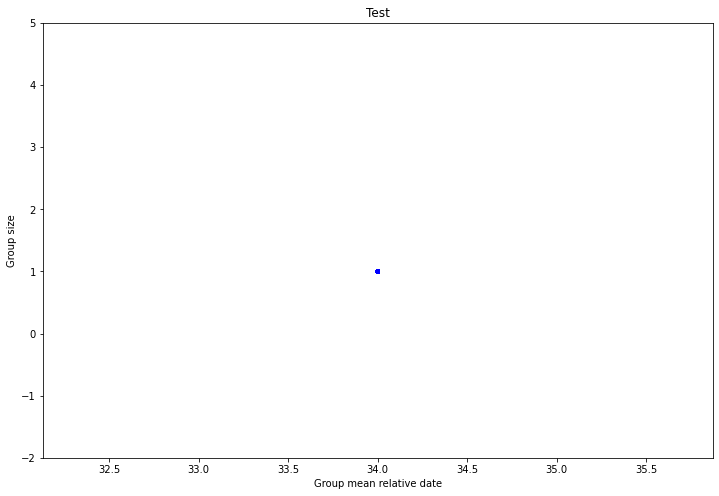

In [25]:
g = sales_test.groupby(['shop_id', 'item_id'])

plt.figure(figsize=(12,8))
plt.scatter(g.date_block_num.mean(),g.size(),edgecolor = 'none',alpha = 0.2, s=20, c='b')
plt.xlabel('Group mean relative date')
plt.ylabel('Group size')
plt.ylim(-2, 5)
plt.title('Test');

del g
gc.collect()

What does that mean? That mean that all groups in test dataset have size of one and labeled by 34th date block num, but that's not surprise for us.

But train dataset has groups with completely different sizes and completely different data. For groups in the top of our triangle we have information about all days, so, that's why their mean date is 16.5. For other groups we don't have full information, that's why their mean date becomes volatile.

Why does this happen? Let's investigate item_cnt_day feature in our dataset. 

In [26]:
sales_train.item_cnt_day.value_counts().sort_index().head(10)

1.0     2182672
2.0      159891
3.0       38381
4.0       15894
5.0        8436
6.0        5114
7.0        3263
8.0        2344
9.0        1749
10.0       1473
Name: item_cnt_day, dtype: int64

So, in the train dataset we find positive and negative values, but don't find zero. Our train dataset just doesn't include data with item_cnt_day equals to zero. So, we most add this combinations to our dataset and set item_cnt_month value for them to zero.

# Create all unique combinations of shop_id, item_id and date_block_num

In [27]:
%%time

from itertools import product

index_cols = ['date_block_num', 'shop_id', 'item_id']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales_train['date_block_num'].unique():
    cur_shops = sales_train[sales_train['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales_train[sales_train['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[[block_num], cur_shops, cur_items])),dtype='int32'))

# turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)

# add revenue column to sales_train
sales_train['item_revenue_day'] = sales_train.item_price.copy() * sales_train.item_cnt_day.copy()

# get aggregated values for (shop_id, item_id, month)
gb = sales_train.groupby(index_cols).agg({'item_cnt_day': ['sum', 'nunique', 'count'], 
                                          'item_revenue_day': 'sum', 
                                          'item_price': 'mean', 
                                          'day': ['first', 'last']
                                         })

# rename columns in gb dataframe
cols = list()
for c in gb.columns: 
    if c[0] == 'day':
        cols.append(c[1] + '_' + c[0])
    elif c[0] == 'item_revenue_day':
        cols.append('item_revenue_month') 
    elif c[0] == 'item_cnt_day' and c[1] == 'sum':
        cols.append('item_cnt_month')
    elif c[0] == 'item_cnt_day' and c[1] == 'count':
        cols.append('item_deals_month')    
    elif c[0] == 'item_cnt_day' and c[1] == 'nunique':
        cols.append('sale_days_in_month')    
    else:
        cols.append(c[0])
        
gb.columns = cols

# join aggregated data to the dataset
all_data = grid.join(gb, on=index_cols)

#sort the data
all_data.sort_values(index_cols, inplace=True)

# add test data
all_data = all_data.append(sales_test.join(gb, how='left', on=index_cols))

CPU times: user 8.71 s, sys: 951 ms, total: 9.66 s
Wall time: 9.27 s


# Add new features

### Add time features for items and shops

In [28]:
%%time

# create dates of first item in the shop, first shop and first item
first_month_day = sales_train.groupby(['date_block_num']).agg({'date': 
                                                               'min'}).rename(columns={'date': 
                                                                                       'first_month_day'})
last_month_day = sales_train.groupby(['date_block_num']).agg({'date': 
                                                               'max'}).rename(columns={'date': 
                                                                                       'last_month_day'})

first_shop_item_date = sales_train.groupby(['shop_id', 
                                            'item_id']).agg({'date': 
                                                             'min'}).rename(columns={'date': 
                                                                                     'first_shop_item_date'})
first_shop_date = sales_train.groupby(['shop_id']).agg({'date': 
                                                        'min'}).rename(columns={'date': 
                                                                                'first_shop_date'})
first_item_date = sales_train.groupby(['item_id']).agg({'date': 
                                                        'min'}).rename(columns={'date': 
                                                                                'first_item_date'})

# add dates of first item in the shop, first shop and first item
all_data = all_data.join(first_month_day, how='left', on=['date_block_num'])
all_data = all_data.join(last_month_day, how='left', on=['date_block_num'])
all_data = all_data.join(first_shop_item_date, how='left', on=['shop_id', 'item_id'])
all_data = all_data.join(first_shop_date, how='left', on=['shop_id'])
all_data = all_data.join(first_item_date, how='left', on=['item_id'])

# reset index for the new dataset
all_data.reset_index(inplace=True, drop=True)

# add first and last days of month to test part of dataset
all_data.loc[all_data.date_block_num == 34, 'first_month_day'] = pd.to_datetime('2015-11-01')
all_data.loc[all_data.date_block_num == 34, 'last_month_day'] = pd.to_datetime('2015-11-30')

# add time differences from first item/shop/item and shop sale to current month
all_data['shop_open_days'] = (all_data.first_month_day - all_data.first_shop_date).dt.days
all_data['item_sale_days'] = (all_data.first_month_day - all_data.first_item_date).dt.days
all_data['item_shop_sale_days'] = (all_data.first_month_day - all_data.first_shop_item_date).dt.days
# add ratio between sale days in month and total days in month
all_data['days_in_month'] = (all_data.last_month_day - all_data.first_month_day).dt.days + 1
all_data['sale_days_ratio'] = all_data.sale_days_in_month/all_data.days_in_month
# add avg numbers of items and deals per sale day
all_data['avg_item_cnt_per_day'] = all_data.item_cnt_month/all_data.sale_days_in_month
all_data['avg_item_deals_per_day'] = all_data.item_deals_month/all_data.sale_days_in_month

# drop columns we don't need
all_data.drop(['first_month_day',
               'last_month_day',
               'sale_days_in_month',
               'first_shop_item_date', 
               'first_shop_date', 
               'first_item_date'], axis=1, inplace=True)

# flll NaN values
all_data.fillna(0, inplace=True)
# clip negative values
all_data.clip(lower=0, inplace=True)

# clean memory
del sales_test, grid, gb, first_shop_item_date, first_shop_date, first_item_date
gc.collect()

all_data.head()

CPU times: user 5.93 s, sys: 2.1 s, total: 8.03 s
Wall time: 6.25 s


,date_block_num,shop_id,item_id,item_cnt_month,item_deals_month,item_revenue_month,item_price,first_day,last_day,shop_open_days,item_sale_days,item_shop_sale_days,days_in_month,sale_days_ratio,avg_item_cnt_per_day,avg_item_deals_per_day
0,0,2,19,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,31,0.000000,0.0,0.0
1,0,2,27,1.0,1.0,2499.0,2499.0,11.0,11.0,0,0.0,0.0,31,0.032258,1.0,1.0
2,0,2,28,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,31,0.000000,0.0,0.0
3,0,2,29,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,31,0.000000,0.0,0.0
4,0,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,31,0.000000,0.0,0.0


### Add feature that shows how many days ago current item was sold by current shop, cumulative items sales and cumulative deals with items.

In [29]:
%%time
from tqdm.auto import tqdm

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

# dictionary for storing of the last date_block for current item in current shop
ids_dict = dict()
# list for storing features for all rows
res = list()

def get_prev_sales(row):
    shop_id, item_id, item_cnt_month, item_deals_month, last_day, days_in_month = row.shop_id, row.item_id, row.item_cnt_month, row.item_deals_month, row.last_day, row.days_in_month
    if (shop_id, item_id) in ids_dict:
        tmp = ids_dict[(shop_id, item_id)].copy()
        # add number of days passed from last sale
        if item_cnt_month != 0:
            ids_dict[(shop_id, item_id)][0] = days_in_month - last_day
        else:
            ids_dict[(shop_id, item_id)][0] += days_in_month
        # increase cumulative number of sales
        ids_dict[(shop_id, item_id)][1] += item_cnt_month
        # increase cumulative number of deals
        ids_dict[(shop_id, item_id)][2] += item_deals_month
    else:
        # if this combination of shop and item id haven't been met in df before, set initial values for it
        tmp = list()
        tmp.append(days_in_month - last_day)
        tmp.append(item_cnt_month)
        tmp.append(item_deals_month)
        ids_dict[(shop_id, item_id)] = tmp
        tmp[0] = 9999
    res.append(tmp.copy())

all_data.progress_apply(get_prev_sales, axis=1)

all_data[['last_saled_days_ago', 
          'item_cnt_month_cumsum', 
          'item_deals_month_cumsum']] = pd.DataFrame(res, columns=['1', '2', '3'])
all_data.drop(['first_day', 'last_day'], axis=1, inplace=True)

del ids_dict, res
gc.collect()

all_data.head()

  0%|          | 0/8856961 [00:00<?, ?it/s]

CPU times: user 4min 14s, sys: 2.23 s, total: 4min 16s
Wall time: 4min 15s


,date_block_num,shop_id,item_id,item_cnt_month,item_deals_month,item_revenue_month,item_price,shop_open_days,item_sale_days,item_shop_sale_days,days_in_month,sale_days_ratio,avg_item_cnt_per_day,avg_item_deals_per_day,last_saled_days_ago,item_cnt_month_cumsum,item_deals_month_cumsum
0,0,2,19,0.0,0.0,0.0,0.0,0,0.0,0.0,31,0.000000,0.0,0.0,9999.0,0.0,0.0
1,0,2,27,1.0,1.0,2499.0,2499.0,0,0.0,0.0,31,0.032258,1.0,1.0,9999.0,1.0,1.0
2,0,2,28,0.0,0.0,0.0,0.0,0,0.0,0.0,31,0.000000,0.0,0.0,9999.0,0.0,0.0
3,0,2,29,0.0,0.0,0.0,0.0,0,0.0,0.0,31,0.000000,0.0,0.0,9999.0,0.0,0.0
4,0,2,32,0.0,0.0,0.0,0.0,0,0.0,0.0,31,0.000000,0.0,0.0,9999.0,0.0,0.0


In [30]:
all_data = reduce_mem_usage(all_data, silent=False)
oldcols = all_data.columns

Memory usage of dataframe is 1114.96 MB
Memory usage after optimization is: 337.87 MB
Decreased by 69.7%


### Add calendar features

In [31]:
import math
import calendar
import holidays
import datetime

date_blocks = pd.DataFrame(all_data.date_block_num.drop_duplicates())

def add_month(col):
    return int(divmod(col, 12)[1] + 1)

def add_year(col):
    return int(2013 + divmod(col+1, 12)[0])

def add_year_month(row):
    return f'{row.year}-{row.month}'

def add_season(col):
    if 0 < col <= 2 or col == 12:
        return 'winter'
    if 3 <= col < 6:
        return 'spring'
    if 6 <= col < 9:
        return 'summer'
    if 9 <= col < 12:
        return 'autumn'
    return np.nan

# get number of holidays + weekend in each month    
ru_holidays = []

for date, name in sorted(holidays.RU(years=[2013, 2014, 2015]).items()):
    ru_holidays.append(date)
    
def add_holidays_and_weekends(row):
    busines_dates = pd.bdate_range(f"{row.year}-{row.month}-01", f"{row.year}-{row.month}-{row.days_in_month}")
    busines_dates = [b for b in busines_dates if b not in ru_holidays]
    return row.days_in_month - len(busines_dates)
    
def create_calendar_features(data):
    data['month'] = data.date_block_num.apply(add_month).astype(np.int8) 
    data['year'] = data.date_block_num.apply(add_year).astype(np.int16) 
    data['year_month'] = data.apply(add_year_month, axis=1)
    data.year_month = pd.to_datetime(data.year_month, format='%Y-%m')
    data['days_in_month'] = data.year_month.dt.daysinmonth.astype(np.int8) 
    data['season'] = data.month.apply(add_season) 
    data['holidays_and_weekends_in_month'] = data.apply(add_holidays_and_weekends, axis=1).astype(np.int8)
    data.drop(['year_month', 'year', 'month', 'days_in_month'], axis=1, inplace=True)


create_calendar_features(date_blocks)
date_blocks.head()

,date_block_num,season,holidays_and_weekends_in_month
0,0,winter,14
267540,1,winter,8
544128,2,spring,11
827196,3,spring,8
1103280,4,spring,10


### Add geographical features

In [32]:
def add_city(col):
    city = col.split(' ')
    if city[0][0] == '!':
        return city[0][1:]
    if city[0] == 'Адыгея':
        return 'Краснодар'
    return city[0]


def add_shop_type(col):
    if 'ТЦ' in col:
        return 1
    if 'ТРЦ' in col or 'МТРЦ' in col:
        return 2
    if 'ТК' in col:
        return 3
    if 'ТРК' in col:
        return 4
    for c in ['Якутск Орджоникидзе', 'Жуковский', 'Воронеж (Плехановская, 13)', 'Магазин С21']:
        if c in col:
            return 5
    return 0


# add features
shops['city'] = shops.shop_name.apply(add_city)
shops['shop_type'] = shops.shop_name.apply(add_shop_type)

shops.head()

,shop_name,shop_id,city,shop_type
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,5
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,1
2,"Адыгея ТЦ ""Мега""",2,Краснодар,1
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,4
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,1


### Add price features

In [33]:
def add_price_features(df, sales_train):
    # Get mean prices per month from train dataframe
    price_features = sales_train.groupby(["date_block_num", "item_id"]).item_price.mean()
    price_features = pd.DataFrame(price_features).reset_index()
    # Calculate normalized differenced from mean category price per month
    price_features = price_features.merge(
        items[["item_id", "item_category_id"]], how="left", on="item_id"
    )
    price_features["norm_diff_cat_price"] = price_features.groupby(
        ["date_block_num", "item_category_id"]
    )["item_price"].transform(lambda x: (x - x.mean()) / x.mean())
    # Retain only the necessary features
    price_features = price_features[
        [
            "date_block_num",
            "item_id",
            "item_price",
            "norm_diff_cat_price",
        ]
    ]

    features = [
        "item_price",
        "norm_diff_cat_price",
    ]
    newnames = ["last_" + f for f in features]
    aggs = {f: "last" for f in features}
    renames = {f: "last_" + f for f in features}
    features = []
    for dbn in range(1, 35):
        f_temp = (
            price_features.query(f"date_block_num<{dbn}")
            .groupby("item_id")
            .agg(aggs)
            .rename(columns=renames)
        )
        f_temp["date_block_num"] = dbn
        features.append(f_temp)
    features = pd.concat(features).reset_index()
    df = df.merge(features, on=["date_block_num", "item_id"], how="left")
    return df

all_data = add_price_features(all_data, sales_train)

del sales_train
gc.collect()

13

### Add features for items and shops

In [34]:
def add_global_category(col):
    cat = col.split(' ')
    if cat[0] == 'Игровые':
        return 'Игровые консоли'
    if cat[0] == 'Карты':
        return 'Карты оплаты'
    if cat[0] == 'Чистые':
        return 'Чистые носители'
    if cat[0] == 'Элементы':
        return 'Элементы питания'
    if cat[0] == 'Доставка':
        return 'Доставка товара'
    return cat[0]

def add_platform(col):
    platform_list = ['PS', 'XBOX', 'PC', 'Android', 'MAC', 'Windows', '1С', 'Blu-Ray',
                    'CD', 'DVD', 'MP3']
    for platform in platform_list:
        if platform in col:
            return platform
    return 'None'

def add_digital(col):
    if 'Цифра' in col:
        return 1
    return 0

def clean_item_name(string):
    # Removes bracketed terms, special characters and extra whitespace
    string = re.sub(r"[^A-ZА-Яa-zа-я0-9 ]", "", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = string.lower()
    return string

def add_item_name_groups(items, thresh=70):
    def strip_brackets(string):
        string = re.sub(r"\(.*?\)", "", string)
        string = re.sub(r"регион", "", string)
        return string

    items = items.copy()
    items['nc'] = items.item_name.apply(strip_brackets)
    items['ncnext'] = np.concatenate((items.nc.to_numpy()[1:], np.array([""])))

    def partialcompare(row):
        return fuzz.partial_ratio(row.nc, row.ncnext)

    items['partialmatch'] = items.apply(partialcompare, axis=1)
        
    # Assign groups
    grp = 0
    for i in range(items.shape[0]):
        items.loc[i, 'item_name_group'] = grp
        if items.loc[i, 'partialmatch'] < thresh:
            grp += 1
    items = items.drop(['nc', 'ncnext', 'partialmatch'], axis=1)
    
    items.item_name_group = items.item_name_group.astype(np.int16)
    
    return items

# add items
items['item_name_cleaned_length'] = items.item_name.apply(clean_item_name).apply(len)
items['item_name_length'] = items.item_name.apply(len)

item_categories['global_category'] = item_categories.item_category_name.apply(add_global_category)
item_categories['platform'] = item_categories.item_category_name.apply(add_platform)

# downcast types
items.item_category_id = items.item_category_id
items.item_name_cleaned_length = items.item_name_cleaned_length
items.item_name_length = items.item_name_length
items = add_item_name_groups(items)

item_categories.item_category_id = item_categories.item_category_id

items.head()

,item_name,item_id,item_category_id,item_name_cleaned_length,item_name_length,item_name_group
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,29,41,0
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,64,68,1
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,19,45,2
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,20,47,2
4,***КОРОБКА (СТЕКЛО) D,4,40,16,43,2


In [35]:
item_categories.head()

,item_category_name,item_category_id,global_category,platform
0,PC - Гарнитуры/Наушники,0,PC,PC
1,Аксессуары - PS2,1,Аксессуары,PS
2,Аксессуары - PS3,2,Аксессуары,PS
3,Аксессуары - PS4,3,Аксессуары,PS
4,Аксессуары - PSP,4,Аксессуары,PS


### Add data from other datasets to train and test datasets

Train dataset

In [36]:
all_data = all_data.join(items.set_index('item_id'), on='item_id')
all_data = all_data.join(item_categories.set_index('item_category_id'), on='item_category_id')
all_data = all_data.join(shops.set_index('shop_id'), on='shop_id')
all_data = all_data.join(date_blocks.set_index('date_block_num'), on='date_block_num')

all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_deals_month,item_revenue_month,item_price,shop_open_days,item_sale_days,item_shop_sale_days,days_in_month,sale_days_ratio,avg_item_cnt_per_day,avg_item_deals_per_day,last_saled_days_ago,item_cnt_month_cumsum,item_deals_month_cumsum,last_item_price,last_norm_diff_cat_price,item_name,item_category_id,item_name_cleaned_length,item_name_length,item_name_group,item_category_name,global_category,platform,shop_name,city,shop_type,season,holidays_and_weekends_in_month
0,0,2,19,0,0,0.0,0.0,0,0,0,31,0.000000,0.0,0.0,9999,0,0,NaN,NaN,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,22,25,15,Кино - DVD,Кино,DVD,"Адыгея ТЦ ""Мега""",Краснодар,1,winter,14
1,0,2,27,1,1,2499.0,2499.0,0,0,0,31,0.032258,1.0,1.0,9999,1,1,NaN,NaN,"007 Legends [PS3, русская версия]",19,30,33,23,Игры - PS3,Игры,PS,"Адыгея ТЦ ""Мега""",Краснодар,1,winter,14
2,0,2,28,0,0,0.0,0.0,0,0,0,31,0.000000,0.0,0.0,9999,0,0,NaN,NaN,"007 Legends [PС, Jewel, русская версия]",30,35,39,23,Игры PC - Стандартные издания,Игры,PC,"Адыгея ТЦ ""Мега""",Краснодар,1,winter,14
3,0,2,29,0,0,0.0,0.0,0,0,0,31,0.000000,0.0,0.0,9999,0,0,NaN,NaN,"007 Legends [Xbox 360, русская версия]",23,35,38,23,Игры - XBOX 360,Игры,XBOX,"Адыгея ТЦ ""Мега""",Краснодар,1,winter,14
4,0,2,32,0,0,0.0,0.0,0,0,0,31,0.000000,0.0,0.0,9999,0,0,NaN,NaN,1+1,40,2,3,25,Кино - DVD,Кино,DVD,"Адыгея ТЦ ""Мега""",Краснодар,1,winter,14


### Drop surplus columns, encode categorical columns

In [37]:
from sklearn.preprocessing import LabelEncoder

all_data.drop(['shop_name', 'item_name', 'item_category_name'], axis=1, inplace=True)

le = LabelEncoder()

cols = ['city', 'season', 'global_category', 'platform']
all_data[cols] = all_data[cols].apply(LabelEncoder().fit_transform)
all_data[cols] = all_data[cols].astype(np.int8)

### Add windowed aggregates

In [38]:
def add_rolling_stats(
    matrix,
    features,
    window=12,
    kind="rolling",
    argfeat="item_cnt_month",
    aggfunc="mean",
    rolling_aggfunc="mean",
    dtype="float16",
    reshape_source=True,
    lag_offset=0,
):
    def rolling_stat(
        matrix,
        source,
        feats,
        feat_name,
        window=12,
        argfeat="item_cnt_month",
        aggfunc="mean",
        dtype=dtype,
        lag_offset=0,
    ):
        # Calculate a statistic on a windowed section of a source table,  grouping on specific features
        store = []
        for i in range(2 + lag_offset, 35 + lag_offset):
            if len(feats) > 0:
                mes = (
                    source[source.date_block_num.isin(range(max([i - window, 0]), i))]
                    .groupby(feats)[argfeat]
                    .agg(aggfunc)
                    .astype(dtype)
                    .rename(feat_name)
                    .reset_index()
                )
            else:
                mes = {}
                mes[feat_name] = (
                    source.loc[
                        source.date_block_num.isin(range(max([i - window, 0]), i)), argfeat
                    ]
                    .agg(aggfunc)
                    .astype(dtype)
                )
                mes = pd.DataFrame(data=mes, index=[i])
            mes["date_block_num"] = i - lag_offset
            store.append(mes)
        store = pd.concat(store)
        matrix = matrix.merge(store, on=feats + ["date_block_num"], how="left")
        return matrix

    """ An issue when using windowed functions is that missing values from months when items recorded no sales are skipped rather than being correctly
    treated as zeroes. Creating a pivot_table fills in the zeros."""
    if (reshape_source == True) or (kind == "ewm"):
        source = matrix.pivot_table(
            index=features + ["date_block_num"],
            values=argfeat,
            aggfunc=aggfunc,
            fill_value=0,
            dropna=False,
        ).astype(dtype)
        for g in features:
            firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
            source = source.merge(firsts, left_on=g, right_index=True, how="left")
            # Set values before the items first appearance to nan so they are ignored rather than being treated as zero sales.
            source.loc[
                source.index.get_level_values("date_block_num") < source["firsts"], argfeat
            ] = float("nan")
            del source["firsts"]
        source = source.reset_index()
    else:
        source = matrix

    if kind == "rolling":
        feat_name = (
            f"{'_'.join(features)}_{argfeat}_{aggfunc}_rolling_{rolling_aggfunc}_win_{window}"
        )
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            matrix,
            source,
            features,
            feat_name,
            window=window,
            argfeat=argfeat,
            aggfunc=rolling_aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "expanding":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_expanding_{rolling_aggfunc}"
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            matrix,
            source,
            features,
            feat_name,
            window=100,
            argfeat=argfeat,
            aggfunc=aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "ewm":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_ewm_hl_{window}"
        print(f'Creating feature "{feat_name}"')
        source[feat_name] = (
            source.groupby(features)[argfeat]
            .ewm(halflife=window, min_periods=1)
            .agg(rolling_aggfunc)
            .to_numpy(dtype=dtype)
        )
        del source[argfeat]
        #         source = source.reset_index()
        source["date_block_num"] += 1 - lag_offset
        return matrix.merge(source, on=["date_block_num"] + features, how="left")

In [39]:
%%time

# mean rolling features
all_data = add_rolling_stats(all_data, ["item_id"], window=12)
all_data = add_rolling_stats(all_data, ["item_id"], kind="ewm", window=1)

all_data = add_rolling_stats(all_data, ["item_category_id"], window=12)
all_data = add_rolling_stats(all_data, ["item_category_id"], kind="ewm", window=1)

all_data = add_rolling_stats(all_data, ["global_category"], window=12)
all_data = add_rolling_stats(all_data, ["global_category"], kind="ewm", window=1)

all_data = add_rolling_stats(all_data, ["item_name_group"], kind="ewm", window=1)
all_data = add_rolling_stats(all_data, ["item_name_group"], window=12)

all_data = add_rolling_stats(all_data, ["platform"], window=12)
all_data = add_rolling_stats(all_data, ["platform"], kind="ewm", window=1)

all_data = add_rolling_stats(all_data, ["shop_id"], window=12)
all_data = add_rolling_stats(all_data, ["shop_id"], kind="ewm", window=1)

all_data = add_rolling_stats(all_data, ["shop_id", "item_id"], window=12)
all_data = add_rolling_stats(all_data, ["shop_id", "item_id"], kind="ewm", window=1)

all_data = add_rolling_stats(all_data, ["shop_id", "item_category_id"], window=12)
all_data = add_rolling_stats(all_data, ["shop_id", "item_category_id"], kind="ewm", window=1)

all_data = add_rolling_stats(all_data, ["shop_id", "global_category"], window=12)
all_data = add_rolling_stats(all_data, ["shop_id", "global_category"], kind="ewm", window=1)


# sum rolling features
all_data = add_rolling_stats(all_data, ["shop_id"], aggfunc="sum", rolling_aggfunc="sum", window=12)
all_data = add_rolling_stats(all_data, ["item_id"], aggfunc="sum", rolling_aggfunc="sum", window=12)

all_data = add_rolling_stats(all_data, ["shop_id", "item_id"], aggfunc="sum", 
                             rolling_aggfunc="sum", window=12)
all_data = add_rolling_stats(all_data, ["shop_id", "item_category_id"], aggfunc="sum", 
                             rolling_aggfunc="sum", window=12)
all_data = add_rolling_stats(all_data, ["shop_id", "global_category"], aggfunc="sum", 
                             rolling_aggfunc="sum", window=12)

# mean revenue features
all_data = add_rolling_stats(all_data, ["shop_id", "item_id"], argfeat="item_revenue_month", window=12)

# sum revenue features
all_data = add_rolling_stats(all_data, ["shop_id"], aggfunc="sum", rolling_aggfunc="sum", 
                             argfeat="item_revenue_month", window=12)
all_data = add_rolling_stats(all_data, ["shop_id", "item_id"], aggfunc="sum", rolling_aggfunc="sum", 
                             argfeat="item_revenue_month", window=12)
all_data = add_rolling_stats(all_data, ["shop_id", "item_category_id"], aggfunc="sum", rolling_aggfunc="sum", 
                             argfeat="item_revenue_month", window=12)

Creating feature "item_id_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "item_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "item_category_id_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "item_category_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "global_category_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "global_category_item_cnt_month_mean_ewm_hl_1"
Creating feature "item_name_group_item_cnt_month_mean_ewm_hl_1"
Creating feature "item_name_group_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "platform_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "platform_item_cnt_month_mean_ewm_hl_1"
Creating feature "shop_id_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "shop_id_item_id_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "shop_id_item_category_id_item_cnt_month_mean_rolling_

In [40]:
all_data = reduce_mem_usage(all_data, silent=False)
oldcols = all_data.columns

Memory usage of dataframe is 1326.13 MB
Memory usage after optimization is: 1495.06 MB
Decreased by -12.7%


### Add sum/mean encoded features

In [41]:
def create_gr_feats(data):
    # create aggregation feats for numeric features based on categorical ones
    for cat_col in ['shop_id', 'item_category_id', 'item_id', 'global_category']:
        # create_col_with_min_freq(data, cat_col, 15,)
        data['mean_' + 'item_cnt_month' + 
             '_by_' + cat_col] = all_data.groupby(['date_block_num', 
                                                   cat_col])['item_cnt_month'].transform(np.mean).astype(np.float32)
        data['sum_' + 'item_cnt_month' + 
             '_by_' + cat_col] = all_data.groupby(['date_block_num', 
                                                   cat_col])['item_cnt_month'].transform(np.sum).astype(np.float32)
        data['mean_' + 'item_price' + 
             '_by_' + cat_col] = all_data.groupby(['date_block_num', 
                                                   cat_col])['item_price'].transform(np.mean).astype(np.float32)

create_gr_feats(all_data)

all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_deals_month,item_revenue_month,item_price,shop_open_days,item_sale_days,item_shop_sale_days,days_in_month,sale_days_ratio,avg_item_cnt_per_day,avg_item_deals_per_day,last_saled_days_ago,item_cnt_month_cumsum,item_deals_month_cumsum,last_item_price,last_norm_diff_cat_price,item_category_id,item_name_cleaned_length,item_name_length,item_name_group,global_category,platform,city,shop_type,season,holidays_and_weekends_in_month,item_id_item_cnt_month_mean_rolling_mean_win_12,item_id_item_cnt_month_mean_ewm_hl_1,item_category_id_item_cnt_month_mean_rolling_mean_win_12,item_category_id_item_cnt_month_mean_ewm_hl_1,global_category_item_cnt_month_mean_rolling_mean_win_12,global_category_item_cnt_month_mean_ewm_hl_1,item_name_group_item_cnt_month_mean_ewm_hl_1,item_name_group_item_cnt_month_mean_rolling_mean_win_12,platform_item_cnt_month_mean_rolling_mean_win_12,platform_item_cnt_month_mean_ewm_hl_1,shop_id_item_cnt_month_mean_rolling_mean_win_12,shop_id_item_cnt_month_mean_ewm_hl_1,shop_id_item_id_item_cnt_month_mean_rolling_mean_win_12,shop_id_item_id_item_cnt_month_mean_ewm_hl_1,shop_id_item_category_id_item_cnt_month_mean_rolling_mean_win_12,shop_id_item_category_id_item_cnt_month_mean_ewm_hl_1,shop_id_global_category_item_cnt_month_mean_rolling_mean_win_12,shop_id_global_category_item_cnt_month_mean_ewm_hl_1,shop_id_item_cnt_month_sum_rolling_sum_win_12,item_id_item_cnt_month_sum_rolling_sum_win_12,shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12,shop_id_item_category_id_item_cnt_month_sum_rolling_sum_win_12,shop_id_global_category_item_cnt_month_sum_rolling_sum_win_12,shop_id_item_id_item_revenue_month_mean_rolling_mean_win_12,shop_id_item_revenue_month_sum_rolling_sum_win_12,shop_id_item_id_item_revenue_month_sum_rolling_sum_win_12,shop_id_item_category_id_item_revenue_month_sum_rolling_sum_win_12,mean_item_cnt_month_by_shop_id,sum_item_cnt_month_by_shop_id,mean_item_price_by_shop_id,mean_item_cnt_month_by_item_category_id,sum_item_cnt_month_by_item_category_id,mean_item_price_by_item_category_id,mean_item_cnt_month_by_item_id,sum_item_cnt_month_by_item_id,mean_item_price_by_item_id,mean_item_cnt_month_by_global_category,sum_item_cnt_month_by_global_category,mean_item_price_by_global_category
0,0,2,19,0,0,0.0,0.0,0,0,0,31,0.000000,0.0,0.0,9999,0,0,NaN,NaN,40,22,25,15,7,4,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.150576,1151.0,85.093864,0.314223,24987.0,36.908409,0.028571,1.0,0.800000,0.289820,32186.0,56.936478
1,0,2,27,1,1,2499.0,2499.0,0,0,0,31,0.032258,1.0,1.0,9999,1,1,NaN,NaN,19,30,33,23,5,9,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.150576,1151.0,85.093864,0.873957,6913.0,495.578522,0.200000,7.0,465.000000,1.020772,36906.0,312.033325
2,0,2,28,0,0,0.0,0.0,0,0,0,31,0.000000,0.0,0.0,9999,0,0,NaN,NaN,30,35,39,23,5,8,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.150576,1151.0,85.093864,1.286222,17737.0,135.897614,0.228571,8.0,78.428574,1.020772,36906.0,312.033325
3,0,2,29,0,0,0.0,0.0,0,0,0,31,0.000000,0.0,0.0,9999,0,0,NaN,NaN,23,35,38,23,5,11,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.150576,1151.0,85.093864,0.588214,3294.0,501.590118,0.142857,5.0,268.200012,1.020772,36906.0,312.033325
4,0,2,32,0,0,0.0,0.0,0,0,0,31,0.000000,0.0,0.0,9999,0,0,NaN,NaN,40,2,3,25,7,4,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.150576,1151.0,85.093864,0.314223,24987.0,36.908409,6.800000,238.0,281.730438,0.289820,32186.0,56.936478


### Add lagged item_cnt features

In [42]:
%%time

index_cols = ['date_block_num', 'shop_id', 'item_id']

target_cols = ['item_cnt_month', 'item_deals_month', 'item_revenue_month', 
               'sale_days_ratio', 'avg_item_cnt_per_day', 'avg_item_deals_per_day']

def create_item_cnt_lagged_features(df, col, win):
    for w in tqdm_notebook(win):
        
        tmp = df[index_cols + [col]].copy()
        
        tmp.date_block_num = tmp.date_block_num + w
        
        foo = lambda x: f'{x}_lag_{w}' if x == col else x
        tmp.rename(columns=foo, inplace=True)

        df = df.join(tmp.set_index(index_cols), on=index_cols)
        
        del tmp
        gc.collect()
        
    return df

        
for col in target_cols:
    if col in ['item_revenue_month', 'sale_days_ratio']:
        all_data = create_item_cnt_lagged_features(all_data, col, [1])
    else:
        all_data = create_item_cnt_lagged_features(all_data, col, [1, 2, 3])

# drop all mean encoded columns, except item_cnt_month
target_cols.remove('item_cnt_month')
all_data.drop(target_cols, axis=1, inplace=True)

all_data.head()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 42.8 s, sys: 13.5 s, total: 56.3 s
Wall time: 56.3 s


,date_block_num,shop_id,item_id,item_cnt_month,item_price,shop_open_days,item_sale_days,item_shop_sale_days,days_in_month,last_saled_days_ago,item_cnt_month_cumsum,item_deals_month_cumsum,last_item_price,last_norm_diff_cat_price,item_category_id,item_name_cleaned_length,item_name_length,item_name_group,global_category,platform,city,shop_type,season,holidays_and_weekends_in_month,item_id_item_cnt_month_mean_rolling_mean_win_12,item_id_item_cnt_month_mean_ewm_hl_1,item_category_id_item_cnt_month_mean_rolling_mean_win_12,item_category_id_item_cnt_month_mean_ewm_hl_1,global_category_item_cnt_month_mean_rolling_mean_win_12,global_category_item_cnt_month_mean_ewm_hl_1,item_name_group_item_cnt_month_mean_ewm_hl_1,item_name_group_item_cnt_month_mean_rolling_mean_win_12,platform_item_cnt_month_mean_rolling_mean_win_12,platform_item_cnt_month_mean_ewm_hl_1,shop_id_item_cnt_month_mean_rolling_mean_win_12,shop_id_item_cnt_month_mean_ewm_hl_1,shop_id_item_id_item_cnt_month_mean_rolling_mean_win_12,shop_id_item_id_item_cnt_month_mean_ewm_hl_1,shop_id_item_category_id_item_cnt_month_mean_rolling_mean_win_12,shop_id_item_category_id_item_cnt_month_mean_ewm_hl_1,shop_id_global_category_item_cnt_month_mean_rolling_mean_win_12,shop_id_global_category_item_cnt_month_mean_ewm_hl_1,shop_id_item_cnt_month_sum_rolling_sum_win_12,item_id_item_cnt_month_sum_rolling_sum_win_12,shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12,shop_id_item_category_id_item_cnt_month_sum_rolling_sum_win_12,shop_id_global_category_item_cnt_month_sum_rolling_sum_win_12,shop_id_item_id_item_revenue_month_mean_rolling_mean_win_12,shop_id_item_revenue_month_sum_rolling_sum_win_12,shop_id_item_id_item_revenue_month_sum_rolling_sum_win_12,shop_id_item_category_id_item_revenue_month_sum_rolling_sum_win_12,mean_item_cnt_month_by_shop_id,sum_item_cnt_month_by_shop_id,mean_item_price_by_shop_id,mean_item_cnt_month_by_item_category_id,sum_item_cnt_month_by_item_category_id,mean_item_price_by_item_category_id,mean_item_cnt_month_by_item_id,sum_item_cnt_month_by_item_id,mean_item_price_by_item_id,mean_item_cnt_month_by_global_category,sum_item_cnt_month_by_global_category,mean_item_price_by_global_category,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_deals_month_lag_1,item_deals_month_lag_2,item_deals_month_lag_3,item_revenue_month_lag_1,sale_days_ratio_lag_1,avg_item_cnt_per_day_lag_1,avg_item_cnt_per_day_lag_2,avg_item_cnt_per_day_lag_3,avg_item_deals_per_day_lag_1,avg_item_deals_per_day_lag_2,avg_item_deals_per_day_lag_3
0,0,2,19,0,0.0,0,0,0,31,9999,0,0,NaN,NaN,40,22,25,15,7,4,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.150576,1151.0,85.093864,0.314223,24987.0,36.908409,0.028571,1.0,0.800000,0.289820,32186.0,56.936478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1,2499.0,0,0,0,31,9999,1,1,NaN,NaN,19,30,33,23,5,9,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.150576,1151.0,85.093864,0.873957,6913.0,495.578522,0.200000,7.0,465.000000,1.020772,36906.0,312.033325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0,0.0,0,0,0,31,9999,0,0,NaN,NaN,30,35,39,23,5,8,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.150576,1151.0,85.093864,1.286222,17737.0,135.897614,0.228571,8.0,78.428574,1.020772,36906.0,312.033325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0,0.0,0,0,0,31,9999,0,0,NaN,NaN,23,35,38,23,5,11,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.150576,1151.0,85.093864,0.588214,3294.0,501.590118,0.142857,5.0,268.200012,1.020772,36906.0,312.033325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0,0.0,0,0,0,31,9999,0,0,NaN,NaN,40,2,3,25,7,4,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

### Add lagged mean and sum item_cnt features

In [43]:
%%time

target_cols = [c for c in all_data.columns if c.startswith('sum_item_cnt')]
target_cols += [c for c in all_data.columns if c.startswith('mean_item_cnt')]

def create_item_cnt_lagged_features(df, win):
    for w in tqdm_notebook(win):
        
        tmp = df[index_cols + target_cols].copy()
        
        tmp.date_block_num = tmp.date_block_num + w
        
        foo = lambda x: f'{x}_lag_{w}' if x in target_cols else x
        tmp.rename(columns=foo, inplace=True)

        df = df.join(tmp.set_index(index_cols), on=index_cols)
        
        del tmp
        gc.collect()
    
    return df

        
all_data = create_item_cnt_lagged_features(all_data, [1])

# drop all mean and sum encoded item_cnt columns
all_data.drop(target_cols, axis=1, inplace=True)

all_data.head()

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 3.56 s, sys: 1.16 s, total: 4.72 s
Wall time: 4.71 s


,date_block_num,shop_id,item_id,item_cnt_month,item_price,shop_open_days,item_sale_days,item_shop_sale_days,days_in_month,last_saled_days_ago,item_cnt_month_cumsum,item_deals_month_cumsum,last_item_price,last_norm_diff_cat_price,item_category_id,item_name_cleaned_length,item_name_length,item_name_group,global_category,platform,city,shop_type,season,holidays_and_weekends_in_month,item_id_item_cnt_month_mean_rolling_mean_win_12,item_id_item_cnt_month_mean_ewm_hl_1,item_category_id_item_cnt_month_mean_rolling_mean_win_12,item_category_id_item_cnt_month_mean_ewm_hl_1,global_category_item_cnt_month_mean_rolling_mean_win_12,global_category_item_cnt_month_mean_ewm_hl_1,item_name_group_item_cnt_month_mean_ewm_hl_1,item_name_group_item_cnt_month_mean_rolling_mean_win_12,platform_item_cnt_month_mean_rolling_mean_win_12,platform_item_cnt_month_mean_ewm_hl_1,shop_id_item_cnt_month_mean_rolling_mean_win_12,shop_id_item_cnt_month_mean_ewm_hl_1,shop_id_item_id_item_cnt_month_mean_rolling_mean_win_12,shop_id_item_id_item_cnt_month_mean_ewm_hl_1,shop_id_item_category_id_item_cnt_month_mean_rolling_mean_win_12,shop_id_item_category_id_item_cnt_month_mean_ewm_hl_1,shop_id_global_category_item_cnt_month_mean_rolling_mean_win_12,shop_id_global_category_item_cnt_month_mean_ewm_hl_1,shop_id_item_cnt_month_sum_rolling_sum_win_12,item_id_item_cnt_month_sum_rolling_sum_win_12,shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12,shop_id_item_category_id_item_cnt_month_sum_rolling_sum_win_12,shop_id_global_category_item_cnt_month_sum_rolling_sum_win_12,shop_id_item_id_item_revenue_month_mean_rolling_mean_win_12,shop_id_item_revenue_month_sum_rolling_sum_win_12,shop_id_item_id_item_revenue_month_sum_rolling_sum_win_12,shop_id_item_category_id_item_revenue_month_sum_rolling_sum_win_12,mean_item_price_by_shop_id,mean_item_price_by_item_category_id,mean_item_price_by_item_id,mean_item_price_by_global_category,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_deals_month_lag_1,item_deals_month_lag_2,item_deals_month_lag_3,item_revenue_month_lag_1,sale_days_ratio_lag_1,avg_item_cnt_per_day_lag_1,avg_item_cnt_per_day_lag_2,avg_item_cnt_per_day_lag_3,avg_item_deals_per_day_lag_1,avg_item_deals_per_day_lag_2,avg_item_deals_per_day_lag_3,sum_item_cnt_month_by_shop_id_lag_1,sum_item_cnt_month_by_item_category_id_lag_1,sum_item_cnt_month_by_item_id_lag_1,sum_item_cnt_month_by_global_category_lag_1,mean_item_cnt_month_by_shop_id_lag_1,mean_item_cnt_month_by_item_category_id_lag_1,mean_item_cnt_month_by_item_id_lag_1,mean_item_cnt_month_by_global_category_lag_1
0,0,2,19,0,0.0,0,0,0,31,9999,0,0,NaN,NaN,40,22,25,15,7,4,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.093864,36.908409,0.800000,56.936478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1,2499.0,0,0,0,31,9999,1,1,NaN,NaN,19,30,33,23,5,9,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.093864,495.578522,465.000000,312.033325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0,0.0,0,0,0,31,9999,0,0,NaN,NaN,30,35,39,23,5,8,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.093864,135.897614,78.428574,312.033325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0,0.0,0,0,0,31,9999,0,0,NaN,NaN,23,35,38,23,5,11,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.093864,501.590118,268.200012,312.033325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0,0.0,0,0,0,31,9999,0,0,NaN,NaN,40,2,3,25,7,4,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.093864,36.908409,281.

### Add lagged mean item_price features

In [44]:
%%time

target_cols = [c for c in all_data.columns if c.startswith('mean_item_price', 0, 15)]

def create_item_price_lagged_features(df, win):
    win = [1]
    for w in tqdm_notebook(win):
        
        tmp = df[index_cols + target_cols].copy()
        
        tmp.date_block_num = tmp.date_block_num + w
        
        foo = lambda x: f'{x}_lag_{w}' if x in target_cols else x
        tmp.rename(columns=foo, inplace=True)

        df = df.join(tmp.set_index(index_cols), on=index_cols)
        
        del tmp
        gc.collect()
        
    return df


all_data = create_item_price_lagged_features(all_data, [1])

# drop all mean encoded item_price columns
all_data.drop(target_cols + ['item_price'], axis=1, inplace=True)

all_data.head()

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 3.44 s, sys: 1.11 s, total: 4.55 s
Wall time: 4.54 s


,date_block_num,shop_id,item_id,item_cnt_month,shop_open_days,item_sale_days,item_shop_sale_days,days_in_month,last_saled_days_ago,item_cnt_month_cumsum,item_deals_month_cumsum,last_item_price,last_norm_diff_cat_price,item_category_id,item_name_cleaned_length,item_name_length,item_name_group,global_category,platform,city,shop_type,season,holidays_and_weekends_in_month,item_id_item_cnt_month_mean_rolling_mean_win_12,item_id_item_cnt_month_mean_ewm_hl_1,item_category_id_item_cnt_month_mean_rolling_mean_win_12,item_category_id_item_cnt_month_mean_ewm_hl_1,global_category_item_cnt_month_mean_rolling_mean_win_12,global_category_item_cnt_month_mean_ewm_hl_1,item_name_group_item_cnt_month_mean_ewm_hl_1,item_name_group_item_cnt_month_mean_rolling_mean_win_12,platform_item_cnt_month_mean_rolling_mean_win_12,platform_item_cnt_month_mean_ewm_hl_1,shop_id_item_cnt_month_mean_rolling_mean_win_12,shop_id_item_cnt_month_mean_ewm_hl_1,shop_id_item_id_item_cnt_month_mean_rolling_mean_win_12,shop_id_item_id_item_cnt_month_mean_ewm_hl_1,shop_id_item_category_id_item_cnt_month_mean_rolling_mean_win_12,shop_id_item_category_id_item_cnt_month_mean_ewm_hl_1,shop_id_global_category_item_cnt_month_mean_rolling_mean_win_12,shop_id_global_category_item_cnt_month_mean_ewm_hl_1,shop_id_item_cnt_month_sum_rolling_sum_win_12,item_id_item_cnt_month_sum_rolling_sum_win_12,shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12,shop_id_item_category_id_item_cnt_month_sum_rolling_sum_win_12,shop_id_global_category_item_cnt_month_sum_rolling_sum_win_12,shop_id_item_id_item_revenue_month_mean_rolling_mean_win_12,shop_id_item_revenue_month_sum_rolling_sum_win_12,shop_id_item_id_item_revenue_month_sum_rolling_sum_win_12,shop_id_item_category_id_item_revenue_month_sum_rolling_sum_win_12,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_deals_month_lag_1,item_deals_month_lag_2,item_deals_month_lag_3,item_revenue_month_lag_1,sale_days_ratio_lag_1,avg_item_cnt_per_day_lag_1,avg_item_cnt_per_day_lag_2,avg_item_cnt_per_day_lag_3,avg_item_deals_per_day_lag_1,avg_item_deals_per_day_lag_2,avg_item_deals_per_day_lag_3,sum_item_cnt_month_by_shop_id_lag_1,sum_item_cnt_month_by_item_category_id_lag_1,sum_item_cnt_month_by_item_id_lag_1,sum_item_cnt_month_by_global_category_lag_1,mean_item_cnt_month_by_shop_id_lag_1,mean_item_cnt_month_by_item_category_id_lag_1,mean_item_cnt_month_by_item_id_lag_1,mean_item_cnt_month_by_global_category_lag_1,mean_item_price_by_shop_id_lag_1,mean_item_price_by_item_category_id_lag_1,mean_item_price_by_item_id_lag_1,mean_item_price_by_global_category_lag_1
0,0,2,19,0,0,0,0,31,9999,0,0,NaN,NaN,40,22,25,15,7,4,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1,0,0,0,31,9999,1,1,NaN,NaN,19,30,33,23,5,9,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0,0,0,0,31,9999,0,0,NaN,NaN,30,35,39,23,5,8,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0,0,0,0,31,9999,0,0,NaN,NaN,23,35,38,23,5,11,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0,0,0,0,31,9999,0,0,NaN,NaN,40,2,3,25,7,4,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Feature interactions: add number of sales for closest item IDs

In [45]:
%%time

index_cols = ['date_block_num', 'shop_id', 'item_id']

def add_closest_ids(win):
    global all_data

    target_cols = [f'item_cnt_month_lag_{w}' for w in win]
    
    # add previous sales of items with next id
    tmp = all_data[index_cols + target_cols].copy()

    tmp.item_id = tmp.item_id + 1

    foo = lambda x: f'{x}_prev_id' if x in target_cols else x
    tmp.rename(columns=foo, inplace=True)

    all_data = all_data.join(tmp.set_index(index_cols), on=index_cols)
    
    del tmp
    gc.collect()
    
    # add previous sales of items with previous id
    tmp = all_data[index_cols + target_cols].copy()
    
    tmp.item_id = tmp.item_id - 1

    foo = lambda x: f'{x}_next_id' if x in target_cols else x
    tmp.rename(columns=foo, inplace=True)

    all_data = all_data.join(tmp.set_index(index_cols), on=index_cols)

    del tmp
    gc.collect()

add_closest_ids([1])

all_data.head()

CPU times: user 6.73 s, sys: 1.84 s, total: 8.57 s
Wall time: 8.56 s


,date_block_num,shop_id,item_id,item_cnt_month,shop_open_days,item_sale_days,item_shop_sale_days,days_in_month,last_saled_days_ago,item_cnt_month_cumsum,item_deals_month_cumsum,last_item_price,last_norm_diff_cat_price,item_category_id,item_name_cleaned_length,item_name_length,item_name_group,global_category,platform,city,shop_type,season,holidays_and_weekends_in_month,item_id_item_cnt_month_mean_rolling_mean_win_12,item_id_item_cnt_month_mean_ewm_hl_1,item_category_id_item_cnt_month_mean_rolling_mean_win_12,item_category_id_item_cnt_month_mean_ewm_hl_1,global_category_item_cnt_month_mean_rolling_mean_win_12,global_category_item_cnt_month_mean_ewm_hl_1,item_name_group_item_cnt_month_mean_ewm_hl_1,item_name_group_item_cnt_month_mean_rolling_mean_win_12,platform_item_cnt_month_mean_rolling_mean_win_12,platform_item_cnt_month_mean_ewm_hl_1,shop_id_item_cnt_month_mean_rolling_mean_win_12,shop_id_item_cnt_month_mean_ewm_hl_1,shop_id_item_id_item_cnt_month_mean_rolling_mean_win_12,shop_id_item_id_item_cnt_month_mean_ewm_hl_1,shop_id_item_category_id_item_cnt_month_mean_rolling_mean_win_12,shop_id_item_category_id_item_cnt_month_mean_ewm_hl_1,shop_id_global_category_item_cnt_month_mean_rolling_mean_win_12,shop_id_global_category_item_cnt_month_mean_ewm_hl_1,shop_id_item_cnt_month_sum_rolling_sum_win_12,item_id_item_cnt_month_sum_rolling_sum_win_12,shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12,shop_id_item_category_id_item_cnt_month_sum_rolling_sum_win_12,shop_id_global_category_item_cnt_month_sum_rolling_sum_win_12,shop_id_item_id_item_revenue_month_mean_rolling_mean_win_12,shop_id_item_revenue_month_sum_rolling_sum_win_12,shop_id_item_id_item_revenue_month_sum_rolling_sum_win_12,shop_id_item_category_id_item_revenue_month_sum_rolling_sum_win_12,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_deals_month_lag_1,item_deals_month_lag_2,item_deals_month_lag_3,item_revenue_month_lag_1,sale_days_ratio_lag_1,avg_item_cnt_per_day_lag_1,avg_item_cnt_per_day_lag_2,avg_item_cnt_per_day_lag_3,avg_item_deals_per_day_lag_1,avg_item_deals_per_day_lag_2,avg_item_deals_per_day_lag_3,sum_item_cnt_month_by_shop_id_lag_1,sum_item_cnt_month_by_item_category_id_lag_1,sum_item_cnt_month_by_item_id_lag_1,sum_item_cnt_month_by_global_category_lag_1,mean_item_cnt_month_by_shop_id_lag_1,mean_item_cnt_month_by_item_category_id_lag_1,mean_item_cnt_month_by_item_id_lag_1,mean_item_cnt_month_by_global_category_lag_1,mean_item_price_by_shop_id_lag_1,mean_item_price_by_item_category_id_lag_1,mean_item_price_by_item_id_lag_1,mean_item_price_by_global_category_lag_1,item_cnt_month_lag_1_prev_id,item_cnt_month_lag_1_next_id
0,0,2,19,0,0,0,0,31,9999,0,0,NaN,NaN,40,22,25,15,7,4,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1,0,0,0,31,9999,1,1,NaN,NaN,19,30,33,23,5,9,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0,0,0,0,31,9999,0,0,NaN,NaN,30,35,39,23,5,8,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0,0,0,0,31,9999,0,0,NaN,NaN,23,35,38,23,5,11,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0,0,0,0,31,9999,0,0,NaN,NaN,40,2,3,25,7,4,9,1,3,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [46]:
all_data = reduce_mem_usage(all_data, silent=False)
oldcols = all_data.columns

Memory usage of dataframe is 2534.00 MB
Memory usage after optimization is: 2263.70 MB
Decreased by 10.7%


### Clip target value, fill NaNs

In [47]:
all_data.item_cnt_month.clip(0, 20, inplace=True)

all_data.fillna(0, inplace=True)

### Save file

In [48]:
all_data.to_hdf('all_data.h5', key='df')

# Train model

### Load file

In [49]:
import os
import gc
import numpy as np
import pandas as pd
import multiprocessing as mp
from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

all_data = pd.read_hdf('all_data.h5', key='df')
submission = pd.read_csv("sample_submission.csv.zip")

# Prepare dataset for model training

### Drop unnecessary rows and columns

In [50]:
# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 2].copy()

# Validate model

In [51]:
cat_feats = ['shop_id',
             'item_id',
             'item_category_id',
             'item_name_group',
             'city',
             'platform', 
             'global_category', 
             'season',
             'shop_type']

last_block = 33
dates = all_data['date_block_num']

cols_to_drop = ['item_cnt_month']

# split dataset on train and test sets for model training
X_train = all_data.loc[dates <  last_block].drop(cols_to_drop, axis=1)
X_val = all_data.loc[dates ==  last_block].drop(cols_to_drop, axis=1)
X_test = all_data.loc[dates ==  34].drop(cols_to_drop, axis=1)

y_train = all_data.loc[dates <  last_block, 'item_cnt_month']
y_val = all_data.loc[dates ==  last_block, 'item_cnt_month']

lgb_params = {
            'objective': 'mse',
            'metric': 'rmse',
            'num_leaves': 32,
            'learning_rate': 0.01,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': 1
        }

# fit LGBM
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

gbm = lgb.train(
        lgb_params, 
        lgb_train,
        num_boost_round=1000,
        valid_sets=(lgb_train, lgb_eval),
        categorical_feature=cat_feats,
        verbose_eval=50, 
        early_stopping_rounds = 50)

test_pred_lgb = gbm.predict(X_test)

/home/alex/.local/lib/python3.8/site-packages/lightgbm/basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city', 'global_category', 'item_category_id', 'item_id', 'item_name_group', 'platform', 'season', 'shop_id', 'shop_type']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.971856	valid_1's rmse: 0.839606
[100]	training's rmse: 0.835416	valid_1's rmse: 0.723183
[150]	training's rmse: 0.76759	valid_1's rmse: 0.670634
[200]	training's rmse: 0.732967	valid_1's rmse: 0.650378
[250]	training's rmse: 0.712081	valid_1's rmse: 0.641572
[300]	training's rmse: 0.697843	valid_1's rmse: 0.638103
[350]	training's rmse: 0.687611	valid_1's rmse: 0.63751
[400]	training's rmse: 0.679446	valid_1's rmse: 0.636805
[450]	training's rmse: 0.671971	valid_1's rmse: 0.635373
[500]	training's rmse: 0.666082	valid_1's rmse: 0.634156
[550]	training's rmse: 0.660951	valid_1's rmse: 0.633129
[600]	training's rmse: 0.656349	valid_1's rmse: 0.632209
[650]	training's rmse: 0.652604	valid_1's rmse: 0.631787
[700]	training's rmse: 0.649055	valid_1's rmse: 0.631162
[750]	training's rmse: 0.645901	valid_1's rmse: 0.630539
[800]	training's rmse: 0.643069	valid_1's rmse: 0.630192
[850]	training's rmse: 0.64030

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

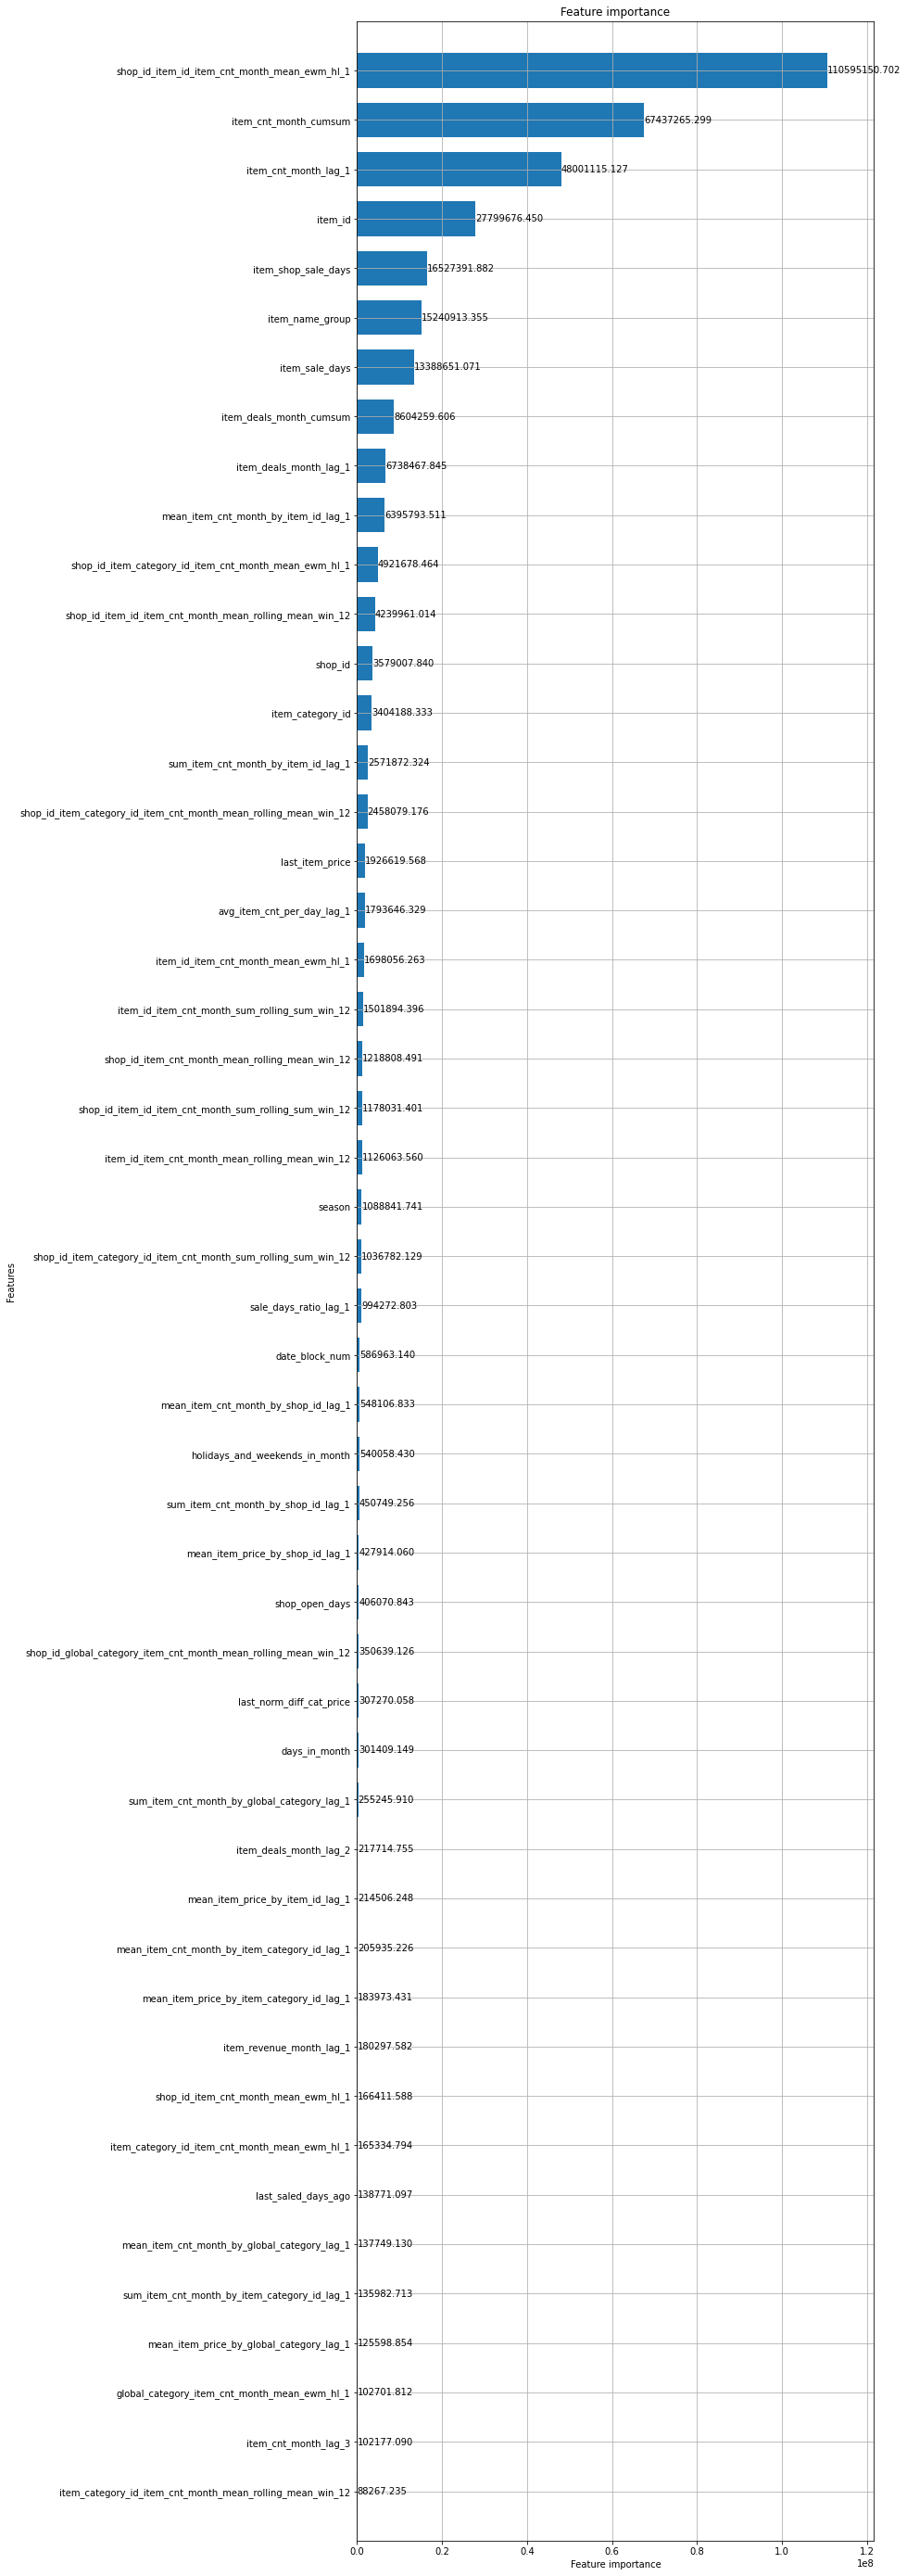

In [52]:
lgb.plot_importance(gbm, figsize=(10,50), height=0.7, importance_type="gain", max_num_features=50)

In [53]:
feat_importance = dict(zip(X_train.columns, gbm.feature_importance()))
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda x: x[1], reverse=True)}
feat_importance

{'item_id': 8631,
 'item_name_group': 4924,
 'item_sale_days': 1469,
 'shop_id': 1311,
 'item_cnt_month_cumsum': 1179,
 'mean_item_cnt_month_by_item_id_lag_1': 921,
 'shop_id_item_id_item_cnt_month_mean_ewm_hl_1': 846,
 'shop_id_item_category_id_item_cnt_month_mean_ewm_hl_1': 781,
 'item_category_id': 753,
 'item_cnt_month_lag_1': 673,
 'item_shop_sale_days': 664,
 'season': 551,
 'sum_item_cnt_month_by_item_id_lag_1': 511,
 'date_block_num': 413,
 'shop_id_item_category_id_item_cnt_month_mean_rolling_mean_win_12': 394,
 'shop_id_item_category_id_item_cnt_month_sum_rolling_sum_win_12': 326,
 'shop_id_item_cnt_month_mean_rolling_mean_win_12': 304,
 'shop_open_days': 303,
 'item_id_item_cnt_month_sum_rolling_sum_win_12': 298,
 'last_item_price': 277,
 'item_deals_month_cumsum': 268,
 'shop_id_item_id_item_cnt_month_mean_rolling_mean_win_12': 264,
 'holidays_and_weekends_in_month': 256,
 'mean_item_cnt_month_by_shop_id_lag_1': 248,
 'last_norm_diff_cat_price': 239,
 'sum_item_cnt_month_by

# Save predictions

In [54]:
import os

submission = pd.read_csv("sample_submission.csv.zip")
submission['item_cnt_month'] = test_pred_lgb
submission.item_cnt_month.clip(0, 20, inplace=True)

submission.to_csv('submission.csv', index=False)

submission.head(10)

,ID,item_cnt_month
0,0,0.951959
1,1,0.130126
2,2,1.763512
3,3,0.582269
4,4,0.033733
5,5,1.037544
6,6,0.697659
7,7,0.185954
8,8,0.640170
9,9,0.432177


In [55]:
X_test.head()

,date_block_num,shop_id,item_id,shop_open_days,item_sale_days,item_shop_sale_days,days_in_month,last_saled_days_ago,item_cnt_month_cumsum,item_deals_month_cumsum,last_item_price,last_norm_diff_cat_price,item_category_id,item_name_cleaned_length,item_name_length,item_name_group,global_category,platform,city,shop_type,season,holidays_and_weekends_in_month,item_id_item_cnt_month_mean_rolling_mean_win_12,item_id_item_cnt_month_mean_ewm_hl_1,item_category_id_item_cnt_month_mean_rolling_mean_win_12,item_category_id_item_cnt_month_mean_ewm_hl_1,global_category_item_cnt_month_mean_rolling_mean_win_12,global_category_item_cnt_month_mean_ewm_hl_1,item_name_group_item_cnt_month_mean_ewm_hl_1,item_name_group_item_cnt_month_mean_rolling_mean_win_12,platform_item_cnt_month_mean_rolling_mean_win_12,platform_item_cnt_month_mean_ewm_hl_1,shop_id_item_cnt_month_mean_rolling_mean_win_12,shop_id_item_cnt_month_mean_ewm_hl_1,shop_id_item_id_item_cnt_month_mean_rolling_mean_win_12,shop_id_item_id_item_cnt_month_mean_ewm_hl_1,shop_id_item_category_id_item_cnt_month_mean_rolling_mean_win_12,shop_id_item_category_id_item_cnt_month_mean_ewm_hl_1,shop_id_global_category_item_cnt_month_mean_rolling_mean_win_12,shop_id_global_category_item_cnt_month_mean_ewm_hl_1,shop_id_item_cnt_month_sum_rolling_sum_win_12,item_id_item_cnt_month_sum_rolling_sum_win_12,shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12,shop_id_item_category_id_item_cnt_month_sum_rolling_sum_win_12,shop_id_global_category_item_cnt_month_sum_rolling_sum_win_12,shop_id_item_id_item_revenue_month_mean_rolling_mean_win_12,shop_id_item_revenue_month_sum_rolling_sum_win_12,shop_id_item_id_item_revenue_month_sum_rolling_sum_win_12,shop_id_item_category_id_item_revenue_month_sum_rolling_sum_win_12,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_deals_month_lag_1,item_deals_month_lag_2,item_deals_month_lag_3,item_revenue_month_lag_1,sale_days_ratio_lag_1,avg_item_cnt_per_day_lag_1,avg_item_cnt_per_day_lag_2,avg_item_cnt_per_day_lag_3,avg_item_deals_per_day_lag_1,avg_item_deals_per_day_lag_2,avg_item_deals_per_day_lag_3,sum_item_cnt_month_by_shop_id_lag_1,sum_item_cnt_month_by_item_category_id_lag_1,sum_item_cnt_month_by_item_id_lag_1,sum_item_cnt_month_by_global_category_lag_1,mean_item_cnt_month_by_shop_id_lag_1,mean_item_cnt_month_by_item_category_id_lag_1,mean_item_cnt_month_by_item_id_lag_1,mean_item_cnt_month_by_global_category_lag_1,mean_item_price_by_shop_id_lag_1,mean_item_price_by_item_category_id_lag_1,mean_item_price_by_item_id_lag_1,mean_item_price_by_global_category_lag_1,item_cnt_month_lag_1_prev_id,item_cnt_month_lag_1_next_id
8642761,34,5,5037,996,416,406,30,56,13,13,1499.000000,0.061675,19,27,30,2606,5,9,2,2,0,10,1.848633,1.530273,0.572266,0.496094,0.585449,0.500488,0.911133,1.188477,0.815918,0.762207,0.21936,0.209717,1.000000,0.737793,0.517090,0.591309,0.400635,0.405762,14672.0,910.0,12.0,1060.0,5652.0,1553.000,inf,18640.0,inf,0.0,1.0,3.0,0.0,1.0,3.0,0.0,0.000000,0.0,1.0,3.0,0.0,1.0,3.0,1054.0,2433.0,25.0,20881.0,0.199659,0.396771,0.595238,0.470356,114.0327,370.971008,606.738098,323.674011,0.0,0.0
8642762,34,5,5320,996,0,0,30,9999,0,0,0.000000,0.000000,55,28,31,2738,9,3,2,2,0,10,0.000000,0.000000,0.235596,0.203735,0.177612,0.153687,0.887695,2.976562,0.234131,0.202637,0.21936,0.209717,0.000000,0.000000,0.177612,0.159302,0.118591,0.105957,14672.0,0.0,0.0,1517.0,1567.0,0.000,inf,0.0,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
8642763,34,5,5233,996,202,168,30,23,10,9,1199.000000,-0.150802,19,51,56,2698,5,9,2,2,0,10,1.697266,1.616211,0.572266,0.496094,0.585449,0.500488,1.298828,0.857910,0.815918,0.762207,0.21936,0.209717,1.428711,1.496094,0.517090,0.591309,0.400635,0.405762,14672.0,488.0,10.0,1060.0,5652.0,1284.000,inf,8992.0,inf,1.0,3.0,1.0,1.0,3.0,1.0,1199.0,0.032258,1.0,3.0,1.0,1.0,3.0,1.0,1054.0,2433.0,42.0,20881.0,0.199659,0.396771,1.000000,0.4

In [56]:
submission.shape

(214200, 2)

# Train model ensemble

### Load data files

# Predict

### Split dataset on train, validation and test sets

# Train model ensemble

We decide to train LGBM and CatBoost models. We also tried to used linear regression, KNN, random forests and extra trees, but linear regression just can't produce the same quality results as boost models can and all other models are too sloooow for training. So we postpone ensembling with them and now try to ensemble two boosting models.

### Create test meta-features

In [ ]:
cat_feats = ['shop_id',
             'item_category_id',
             'city',
             'global_category', 
             'platform',
             'season']

# fit CatBoost
cbr = CatBoostRegressor(
                      iterations=500, 
                      learning_rate=0.05, 
                      loss_function='RMSE',
                      cat_features = cat_feats,
                      metric_period = 50
                    )
cbr.fit(X_train, y_train)
test_pred_cbr = cbr.predict(X_test)

lgb_params = {
            'objective': 'mse',
            'metric': 'rmse',
            'num_leaves': 32,
            'learning_rate': 0.05,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': 1
        }

 # fit LGBM
lgb_train = lgb.Dataset(X_train, y_train)

gbm = lgb.train(
        lgb_params, 
        lgb_train,
        num_boost_round=500,
        valid_sets=lgb_train, 
        categorical_feature=cat_feats,
        verbose_eval=50, 
        early_stopping_rounds = 50)

test_pred_lgb = gbm.predict(X_test)

0:	learn: 1.2084634	total: 3.24s	remaining: 26m 56s


Concatenate two predictions to get test meta-features

In [ ]:
X_test_level2 = np.c_[test_pred_cbr, test_pred_lgb] 

### Create train meta-features

In [ ]:
dates_train_level2 = dates_train[dates_train.isin([30, 31, 32, 33])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([30, 31, 32, 33])]

# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

meta_index_begin = 0
meta_index_end = 0

# Now fill `X_train_level2` with metafeatures
for cur_block_num in tqdm_notebook([30, 31, 32, 33]):
    
    # split data
    train_index = X_train.loc[dates <  cur_block_num].index
    val_index  = X_train.loc[dates == cur_block_num].index
    
    x_train_ = X_train.loc[X_train.index.isin(train_index), :]
    x_val_ =  X_train.loc[X_train.index.isin(val_index), :]

    y_train_ = y_train.loc[y_train.index.isin(train_index)].values
    y_val_ =  y_train.loc[y_train.index.isin(val_index)].values
    
    meta_index_end += y_val_.shape[0]
    
    # fit CatBoost
    cbr = CatBoostRegressor(
                          iterations=500, 
                          learning_rate=0.05, 
                          loss_function='RMSE',
                          cat_features = cat_feats,
                          metric_period = 50
                        )
    cbr.fit(x_train_, y_train_, eval_set=(x_val_, y_val_))
    pred_cbr = cbr.predict(x_val_)
    
    X_train_level2[meta_index_begin:meta_index_end, 0] = pred_cbr
    
    # fit LGBM
    lgb_train = lgb.Dataset(x_train_, y_train_)
    lgb_eval = lgb.Dataset(x_val_, y_val_, reference=lgb_train)
    
    gbm = lgb.train(
            lgb_params, 
            lgb_train,
            num_boost_round=500,
            valid_sets=(lgb_train, lgb_eval), 
            categorical_feature=cat_feats,
            verbose_eval=50, 
            early_stopping_rounds = 50)
    
    pred_lgb = gbm.predict(x_val_)
    
    X_train_level2[meta_index_begin:meta_index_end, 1] = pred_lgb
    
    meta_index_begin = meta_index_end

### Simple convex mix

In [ ]:
alphas_to_try = np.linspace(0, 1, 1001)
   
best_alpha = 0
mse_train_simple_mix = np.inf

for alpha in alphas_to_try:
    mse_mix = mean_squared_error(y_train_level2, alpha*X_train_level2[:, 0] + (1-alpha)*X_train_level2[:, 1])
    if mse_mix < mse_train_simple_mix:
        mse_train_simple_mix = mse_mix
        best_alpha = alpha

print(f'Best alpha: {best_alpha}; Corresponding MSE on train: {mse_train_simple_mix}')

Save meta-features

In [ ]:
np.save('X_train_level2.npy', X_train_level2)
np.save('X_test_level2.npy', X_test_level2)
np.save('y_train_level2.npy', y_train_level2)

# Prediction

### Load meta-features

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

X_train_level2 = np.load('X_train_level2.npy')
X_test_level2 = np.load('X_test_level2.npy')
y_train_level2 = np.load('y_train_level2.npy')

### Predict for the test set with convex mix

In [ ]:
best_alpha = 0.324

test_preds = best_alpha*X_test_level2[:, 0] + (1-best_alpha)*X_test_level2[:, 1]

### Save predictions to the submission file

In [ ]:
submission = pd.read_csv("sample_submission.csv.zip")
submission['item_cnt_month'] = test_preds
submission.item_cnt_month.clip(0, 20, inplace=True)

submission.head(10)

In [ ]:
submission.to_csv('submission_simple_convex_mix.csv', index=False)

### Stacking

In [ ]:
X_train_level2.shape

In [ ]:
y_train_level2.shape

In [ ]:
# fit linear regression
lr = LinearRegression()
lr.fit(X_train_level2, y_train_level2)

test_preds = lr.predict(X_test_level2)

### Save stacking predictions to file

In [ ]:
submission['item_cnt_month'] = test_preds
submission.item_cnt_month.clip(0, 20, inplace=True)

submission.to_csv('submission_stacking.csv', index=False)

submission.head(10)

- Simple convex combination gives us 0.9022 LB score.
- Stacking gives us 0.9023 LB score.
- One finely tuned LGBM model gives us 0.9068 score.

So, even simple stacking with similar model gives us performance boost. 

But there are a lot of space to work with: generate additional features; more complex ensembles with KNN, SVD, RF, ET, NN; additional hyperparameter optimization, etc. We definitely try all of this to imrove the LB score and hit the top.

# Optimize with Optuna

In [ ]:
import optuna.integration.lightgbm as lgb

params = {
    'objective': 'mse',
    'learning_rate': 0.005,
    'metric': 'rmse',
    'verbose': 1
}
cat_feats = ['item_category_id',
             'city',
             'global_category', 
             'platform',
             'season']

# lgb_train = lgb.Dataset(x[feature_name], y)
lgb_train = lgb.Dataset(X_train, y_train)

lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

evals_result = dict()

gbm = lgb.train(
        params, 
        lgb_train,
        valid_sets=(lgb_train, lgb_eval), 
#         valid_sets=lgb_train,
        categorical_feature = cat_feats,
        verbose_eval=50, 
        evals_result = evals_result,
        early_stopping_rounds = 50)

In [ ]:
gbm.params

Feature importance

In [ ]:
lgb.plot_importance(gbm, figsize=(16, 12))

Model learning curve

In [ ]:
lgb.plot_metric(evals_result)

# Make prediction

In [ ]:
y = gbm.predict(X_test)

submission = pd.read_csv("sample_submission.csv.zip")
submission['item_cnt_month'] = y
submission.item_cnt_month.clip(0, 20, inplace=True)

submission.head(10)

# Save to file

In [ ]:
submission.to_csv('submission_lgb_tuned.csv', index=False)

# Futher ideas

- train only for shops that are presented in the test set

- add text description

- add predictive words in item_name
- add percentage change in an aggregate feature
- add number of unique item features
- add shop and item category clustering


# Use LightAutoML to predict sales

In [ ]:
import os
import logging

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
import multiprocessing as mp

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO)

In [ ]:
N_THREADS = mp.cpu_count()
N_FOLDS = 10
RANDOM_STATE = 42
TIMEOUT = 2*3600
TARGET_NAME = 'item_price'


task = Task('reg', loss='mse', metric='mse')
roles = {
    'target': TARGET_NAME
}


In [ ]:
automl = TabularUtilizedAutoML(task=task,
                               timeout=TIMEOUT,
                               cpu_limit=N_THREADS,
                               general_params={'use_algos':
                                                  [['lgb', 'linear_l2', 'cb'],
                                                   ['lgb_tuned'],
                                                   ]},
                               reader_params={'cv': N_FOLDS,
                                             'random_state': RANDOM_STATE,
                                             'n_jobs': N_THREADS},
                               timing_params = {'mode': 0}
                          ) 


oof_pred = automl.fit_predict(X_train, roles=roles)


In [ ]:
y = automl.predict(sales_test2)

submission['item_cnt_month'] = y
submission.item_cnt_month.clip(0, 20, inplace=True)

submission.head(10)

In [ ]:
submission.to_csv('submission.csv', index=False)

Fit KNN

In [ ]:
# %%time

# knn = KNeighborsRegressor(n_jobs=mp.cpu_count())
# knn.fit(X_train.values, y_train.values)
# pred_knn = knn.predict(X_val.values) # there was X_test, restart this string

# # save file 
# np.save('pred_knn.npy', pred_knn)

Fit extra trees

In [ ]:
# %%time

# etr = ExtraTreesRegressor(verbose=1, n_jobs=mp.cpu_count())
# etr.fit(X_train.values, y_train.values)
# pred_etr = etr.predict(X_val.values)

# # save file 
# np.save('pred_etr.npy', pred_etr)

Fit random forest

In [ ]:
# %%time

# rfr = RandomForestRegressor(verbose=1, n_jobs=mp.cpu_count())
# rfr.fit(X_train.values, y_train.values)
# pred_rfr = rfr.predict(X_val.values)

# # save file 
# np.save('pred_rfr.npy', pred_rfr)